In [ ]:
from pathlib import Path
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import io 
import os
import pandas as pd
import torchvision
from keras import backend as K
import torch
from torchvision import datasets, models, transforms
import keras
import tensorflow as tf
from keras.applications import vgg16
from keras.models import Sequential,Model
from keras import layers
from tensorflow import keras
from keras.layers import Dense, Conv2D, Conv2DTranspose,MaxPool2D , Flatten, Input
from keras import optimizers
from tensorflow.keras import utils
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from imutils import paths
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [ ]:
from tensorflow.keras.optimizers import Adam



In [ ]:
#Mount or download kaggle API
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load from drive
os.chdir('drive/MyDrive')
#TRAIN
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
#TEST
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
#VALID
x_valid = np.load('x_valid.npy')
y_valid = np.load('y_valid.npy')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(2000, 256, 256, 3)
(2000, 256, 256)
(600, 256, 256, 3)
(600, 256, 256)
(150, 256, 256, 3)
(150, 256, 256)


In [ ]:
def IoU(y_true, y_pred, smooth=100):
    #output = y_pred[-1].numpy()
    #print(np.unique(output))
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    ans = (intersection + smooth) / (sum_ - intersection + smooth)
 
    return ans

def relu_advanced(alpha = 0.0, max_value = 1, threshold = 0.45):
    def relu_plus(x):
        #Threshold the last layer (output of the network)
        return K.relu(x,
                      max_value=max_value,
                      threshold = threshold)
    return relu_plus

def jaccard_distance(y_true, y_pred, smooth=100):
    return  1 - IoU(y_true,y_pred)
    

In [ ]:
def IoU_score(y_true, y_pred,smooth = 1e-2):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred) - intersection
    ans = (intersection + smooth) / K.abs(sum_ - intersection + smooth)
    return ans

In [ ]:
def threshold(img):
    sub = (model.predict(img.reshape(1,256,256,3))).flatten()
    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [ ]:

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [ ]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
epochs=50
#opt = Adam(lr=0.1, decay=1e-2/epochs)
model.compile(loss=jaccard_distance,
             optimizer=tf.optimizers.Adam(learning_rate=0.00001),
             metrics=[IoU] )

# Train the model, doing validation at the end of each epoch.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15,restore_best_weights = True)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_best_only=True,save_freq=5 * 128,mode='auto', period=1)
history = model.fit(x_train, y_train,epochs=epochs,batch_size=16,validation_data=(x_valid,y_valid))

Epoch 1/50
125/125 [==============================] - 129s 834ms/step - loss: 0.1812 - IoU: 0.8188 - val_loss: 0.2226 - val_IoU: 0.7774
Epoch 2/50
125/125 [==============================] - 106s 850ms/step - loss: 0.1010 - IoU: 0.8990 - val_loss: 0.1304 - val_IoU: 0.8696
Epoch 3/50
125/125 [==============================] - 110s 876ms/step - loss: 0.0808 - IoU: 0.9192 - val_loss: 0.0986 - val_IoU: 0.9014
Epoch 4/50
125/125 [==============================] - 109s 874ms/step - loss: 0.0694 - IoU: 0.9306 - val_loss: 0.0877 - val_IoU: 0.9123
Epoch 5/50
125/125 [==============================] - 109s 876ms/step - loss: 0.0646 - IoU: 0.9354 - val_loss: 0.0838 - val_IoU: 0.9162
Epoch 6/50
125/125 [==============================] - 110s 877ms/step - loss: 0.0626 - IoU: 0.9374 - val_loss: 0.0766 - val_IoU: 0.9234
Epoch 7/50
125/125 [==============================] - 109s 875ms/step - loss: 0.0568 - IoU: 0.9432 - val_loss: 0.0751 - val_IoU: 0.9249
Epoch 8/50
125/125 [============================

In [ ]:
import gc
gc.collect()

In [ ]:
keras.backend.clear_session()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

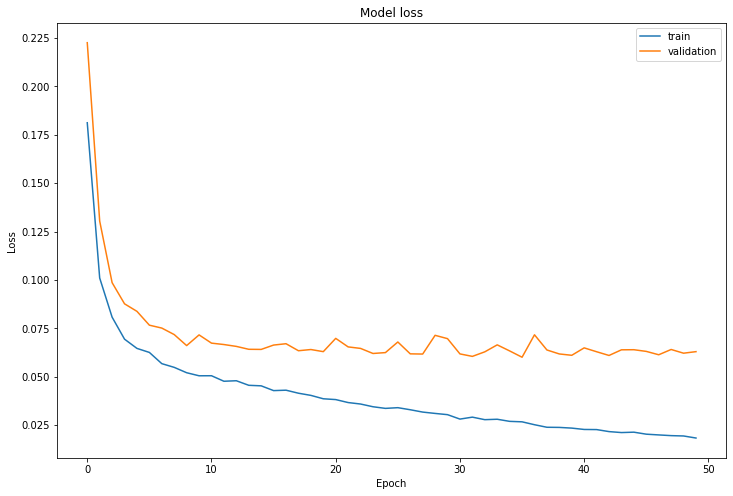

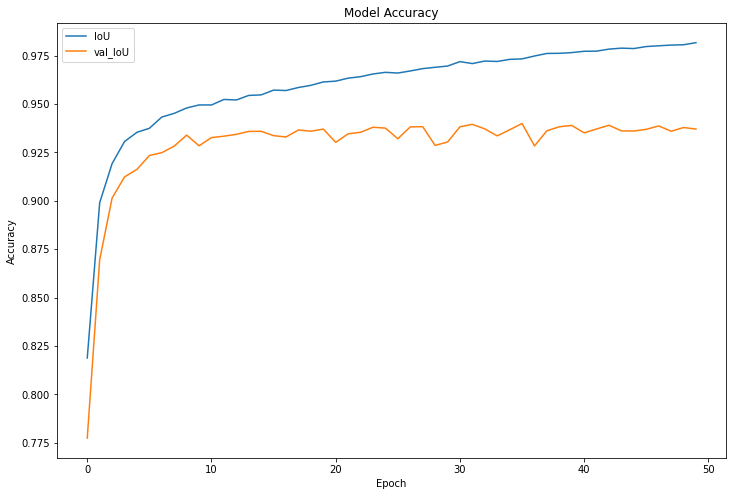

In [ ]:
#PLOTS
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['IoU','val_IoU']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
#Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

IoU: 90.94%


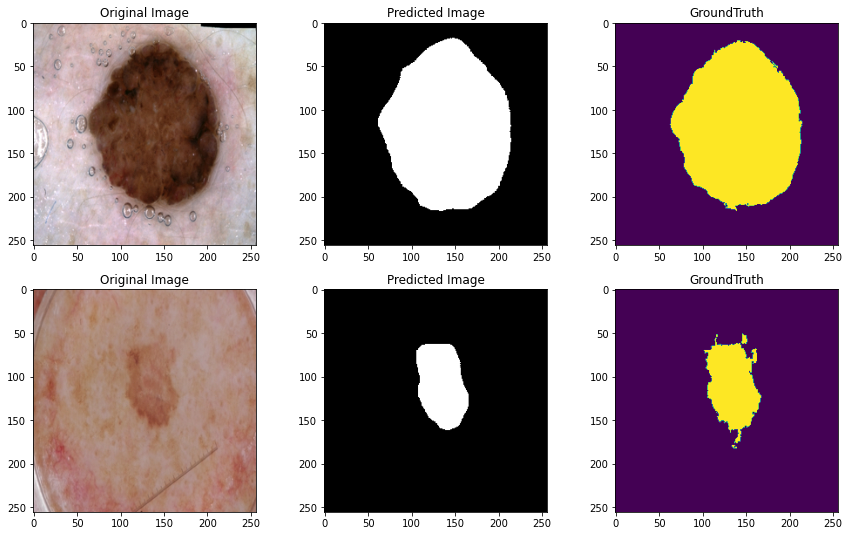

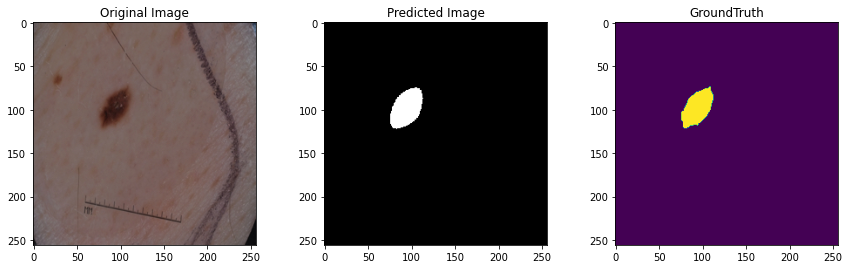

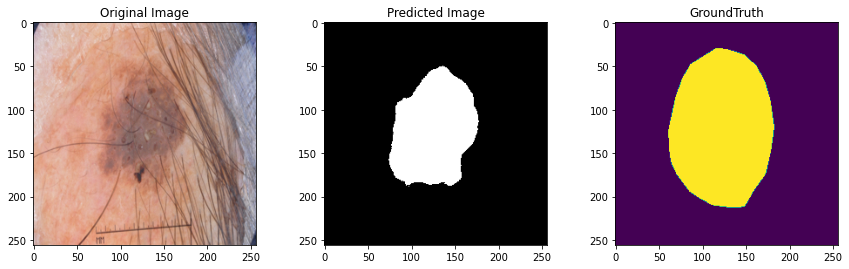

In [ ]:
prediction = np.array(model.predict(x_test))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_test[470])
plt.title("Original Image")
plt.subplot(2,4,2)
plt.imshow(threshold(x_test[470]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(2,4,3)
plt.imshow(y_test[470])
plt.title("GroundTruth")
plt.subplot(2,4,5)
plt.imshow(x_test[25])
plt.title("Original Image")
plt.subplot(2,4,6)
plt.imshow(threshold(x_test[25]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(2,4,7)
plt.imshow(y_test[25])
plt.title("GroundTruth")
plt.show()
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_test[35])
plt.title("Original Image")
plt.subplot(2,4,2)
plt.imshow(threshold(x_test[35]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(2,4,3)
plt.imshow(y_test[35])
plt.title("GroundTruth")
plt.figure(figsize=(20,9))
plt.subplot(2,4,5)
plt.imshow(x_test[45])
plt.title("Original Image")
plt.subplot(2,4,6)
plt.imshow(threshold(x_test[45]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(2,4,7)
plt.imshow(y_test[45])
plt.title("GroundTruth")
plt.show()

tf.Tensor(0.06130671806684547, shape=(), dtype=float64)


Text(0.5, 1.0, 'GroundTruth')

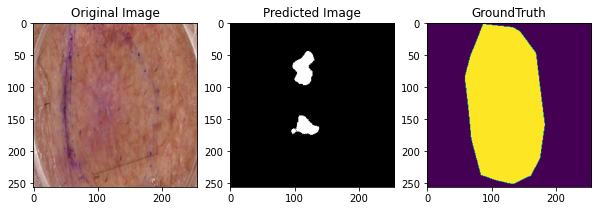

In [ ]:
#Bad
iou = IoU_score(prediction[15],y_test[15])
print(iou)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(x_test[15])
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(threshold(x_test[15]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(1,3,3)
plt.imshow(y_test[15])
plt.title("GroundTruth")

tf.Tensor(0.2554913736226602, shape=(), dtype=float64)


Text(0.5, 1.0, 'GroundTruth')

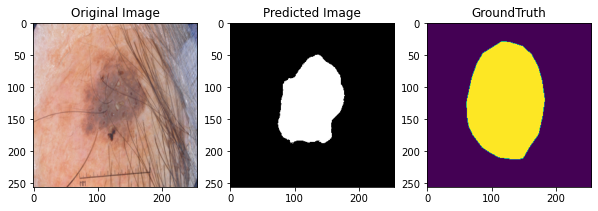

In [ ]:
#Bad
iou = IoU_score(prediction[45],y_test[45])
print(iou)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(x_test[45])
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(threshold(x_test[45]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(1,3,3)
plt.imshow(y_test[45])
plt.title("GroundTruth")

tf.Tensor(0.9318504555510012, shape=(), dtype=float64)


Text(0.5, 1.0, 'GroundTruth')

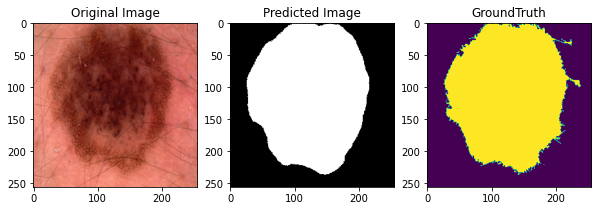

In [ ]:
#Good
iou = IoU_score(prediction[320],y_test[320])
print(iou)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(x_test[320])
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(threshold(x_test[320]).reshape(256,256), plt.cm.binary_r)
plt.title("Predicted Image")
plt.subplot(1,3,3)
plt.imshow(y_test[320])
plt.title("GroundTruth")